In [256]:
import numpy as np
import pandas as pd
import random
import matplotlib
import seaborn as sns

In [257]:
class GridBoard:
    def __init__(self, cols, rows):
        self.rows = rows
        self.cols = cols
        self.rewards = pd.DataFrame(np.zeros((rows, cols)))
        self.walls = []
        #for w in self.walls:
        #   # check here to see if walls within the dataframe boundaries
        #    self.show_board[w[0]][w[1]] = "X"

        self.terminals = []  
        
        self.show_board = pd.DataFrame('.', index=range(self.rows), columns=range(self.cols))

    
    def assignRewards(self, row, col, reward):
        self.rewards[row][col] = reward
        self.terminals.append([row, col])
    
    def reset_showboard(self):
        self.show_board = pd.DataFrame('.', index=range(self.rows), columns=range(self.cols))
        #for w in self.walls:
        #    self.show_board[w[0]][w[1]] = "X"
    
    def set_walls(self, walls):
        for w in walls:
            self.walls.append(w)




In [258]:
class Player:
    def __init__(self, grid, start):
        self.start = start
        self.curr_state = self.start[:]
        grid.show_board[self.curr_state[0]][self.curr_state[1]] = "*"
        self.state_count = pd.DataFrame(np.zeros((grid.rows, grid.cols)))

        # q_tables are a list within a dataframe cell with the directions [North, East, South, West], always start at 0
        self.qtable = pd.DataFrame([[[0, 0, 0, 0] for j in range(grid.cols)] for i in range(grid.rows)], index=range(grid.rows), columns=range(grid.cols))
    
    def move(self, direct):
        # determine if a move can occur
        # possible values for act: N, S, E, W
        # need next_state to find walls

        #next_state = self.detNextState(self.curr_state, direct)

        if direct == 'N':
            next_state = [self.curr_state[0], self.curr_state[1]-1]
            if self.curr_state[1] != 0 and next_state not in grid.walls: self.curr_state[1] -= 1 
            #if next_state not in grid.walls: self.curr_state[1] -= 1

        elif direct == 'E':
            next_state = [self.curr_state[0]+1, self.curr_state[1]]
            if next_state[0] < grid.cols and next_state not in grid.walls: self.curr_state[0] += 1 
            #if next_state not in grid.walls: self.curr_state[1] -= 1

        elif direct == 'S':
            next_state = [self.curr_state[0], self.curr_state[1]+1]
            if next_state[1] < grid.rows and next_state not in grid.walls: self.curr_state[1] += 1 
            #if next_state not in grid.walls: self.curr_state[1] += 1 

        elif direct == 'W':
            next_state = [self.curr_state[0]-1, self.curr_state[1]]
            if self.curr_state[0] != 0 and next_state not in grid.walls: self.curr_state[0] -= 1 
            #if next_state not in grid.walls: self.curr_state[0] -= 1 

        else:
            print("Invalid option")
        grid.reset_showboard()
        grid.show_board[self.curr_state[0]][self.curr_state[1]] = '*'
    
    def detNextState(self, curr_state, direct):

        if direct == 'N': next_state = [self.curr_state[0], self.curr_state[1]-1]
        elif direct == 'E': next_state = [self.curr_state[0]+1, self.curr_state[1]]
        elif direct == 'S': next_state = [self.curr_state[0], self.curr_state[1]+1]
        elif direct == 'W': next_state = [self.curr_state[0]-1, self.curr_state[1]]
        else: print("Invalid option")
        
        return next_state
    
    
    def findRandDirection(self):
        d = random.randint(1,4)
        if d == 1: return 'N'
        elif d == 2: return 'E'
        elif d == 3: return 'S'
        elif d == 4: return 'W'
        else:
            print("out of bounds")



            


In [259]:
class QLearn:
    def __init__(self, gamma, lr, deterministic):
        self.gamma = gamma
        self.deterministic = deterministic
        if not deterministic:
            self.lr = lr
        else:
            self.lr = 1
    
    def findQhat(self, rewards, qtable, cs, ns, d):
        qhat = 0
        if self.deterministic == True:
            if ns not in grid.walls:
                qhat = rewards[ns[0]][ns[1]] + self.gamma * max(qtable[ns[0]][ns[1]][0], qtable[ns[0]][ns[1]][1], qtable[ns[0]][ns[1]][2], qtable[ns[0]][ns[1]][3])
        else:
            if ns not in grid.walls:
                qhat = (1-self.lr) * qtable[cs[0]][cs[1]][d] + \
                    self.lr * (rewards[ns[0]][ns[1]] + self.gamma * \
                    max(qtable[ns[0]][ns[1]][0], qtable[ns[0]][ns[1]][1], qtable[ns[0]][ns[1]][2], qtable[ns[0]][ns[1]][3]))
                #print(qhat)

        return qhat

In [260]:
class Charts():
    def __init__(self, episodes):
        self.stepsGoal = pd.DataFrame(0, columns=['Steps'], index=range(1, episodes+1))
        self.stepsGoal.index.name = 'Episodes'
        #self.stepsGoal.insert(0, 'Episodes', self.stepsGoal.index)

In [261]:
# function to create gridboard, set up walls & boundaries and assign rewards
# recieves: columns, rows, arewards array for rewards
def setupGrid(columns, rows, arewards):
    grid = GridBoard(columns, rows)
    
    # create walls and boundaries, treat out of bounds as walls
    for c in range(0, grid.cols):
        grid.walls.append([c, -1])
        grid.walls.append([c, grid.rows])
    for r in range(0, grid.rows):
        grid.walls.append([-1, r])
        grid.walls.append([grid.cols, r])

    print(grid.walls)

    for reward in arewards:
        grid.assignRewards(reward[0], reward[1], reward[2])

    print(grid.terminals)

    return grid

In [262]:
def getDirInt(direct):
    d = 0
    if direct == 'N': d = 0
    elif direct == 'E': d = 1
    elif direct == 'S': d = 2
    elif direct == 'W': d = 3
    return d

In [263]:
# receives: pdef (if predefined path or not), iterations, path (none if not predefined)
def run(pdef, iters, path):

    #start = player.start
    
    if pdef == False:
        for i in range(0, iters):
            stepCount = 0
            while player.curr_state not in grid.terminals:
                x = player.curr_state[0]
                y = player.curr_state[1]
                direct = player.findRandDirection()
                next_state = player.detNextState(player.curr_state, direct)

                d = getDirInt(direct)

                qhat = qlearn.findQhat(grid.rewards, player.qtable, player.curr_state, next_state, d)
                qhat = round(qhat, 2)

                player.qtable[x][y][d] = qhat

                player.move(direct)

                stepCount += 1

                #print(player.curr_state)
                #print(grid.show_board)                


            charts.stepsGoal['Steps'][i+1] = stepCount
            player.curr_state = player.start[:]
        player.qtable = player.qtable.round(2)
        print(player.qtable)
        print(grid.show_board)
    
    else:   
        for t in path:            
            for direct in t:
                x = player.curr_state[0]
                y = player.curr_state[1]
                #direct = player.findRandDirection()

                next_state = player.detNextState(player.curr_state, direct)

                d = getDirInt(direct)

                qhat = qlearn.findQhat(grid.rewards, player.qtable, player.curr_state, next_state, d)

                qhat = round(qhat, 2)

                player.qtable[x][y][d] = qhat

                player.move(direct)

                #print(player.curr_state)
                #print(grid.show_board)
            player.curr_state = player.start[:]

        player.qtable = player.qtable.round(2)
        print(player.qtable)
        print(grid.show_board)

In [264]:
aRewards = [[0, 2, 25], [1, 2, -100], [1, 0, -80], [2, 2, 80], [2, 0, 100]]

grid = setupGrid(3, 3, aRewards)
player = Player(grid, [0, 0])
qlearn = QLearn(0.5, 0.5, False)
iters = 10


print(player.curr_state)
print(grid.show_board)

path = [['S', 'E', 'S'], ['S', 'E', 'E', 'N'], ['S', 'E', 'E', 'S']]

run(True, iters, path)







[[0, -1], [0, 3], [1, -1], [1, 3], [2, -1], [2, 3], [-1, 0], [3, 0], [-1, 1], [3, 1], [-1, 2], [3, 2]]
[[0, 2], [1, 2], [1, 0], [2, 2], [2, 0]]
[0, 0]
   0  1  2
0  *  .  .
1  .  .  .
2  .  .  .
                0                    1                   2
0  [0, 0, 0.0, 0]         [0, 0, 0, 0]        [0, 0, 0, 0]
1  [0, 0.0, 0, 0]  [0, 12.5, -50.0, 0]  [50.0, 0, 40.0, 0]
2    [0, 0, 0, 0]         [0, 0, 0, 0]        [0, 0, 0, 0]
   0  1  2
0  .  .  .
1  .  .  .
2  .  .  *


[[0, -1], [0, 2], [1, -1], [1, 2], [2, -1], [2, 2], [-1, 0], [3, 0], [-1, 1], [3, 1]]
[[2, 0]]
                    0                       1                   2
0  [0, 90.0, 72.9, 0]  [0, 100.0, 81.0, 81.0]        [0, 0, 0, 0]
1  [81.0, 81.0, 0, 0]   [90.0, 90.0, 0, 72.9]  [100.0, 0, 0, 0.0]
   0  1  2
0  .  .  *
1  .  .  .
          Steps
Episodes       
1            13
2            36
3            18
4            21
5             6
6            21
7             7
8             7
9             9
10           12


<AxesSubplot:xlabel='Episodes'>

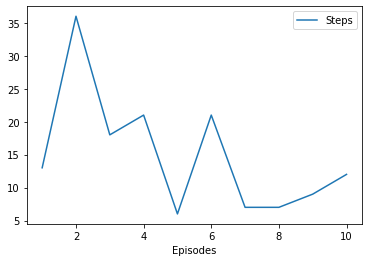

In [265]:
aRewards = [[2, 0, 100]]

grid = setupGrid(3, 2, aRewards)
player = Player(grid, [0, 1])
qlearn = QLearn(0.9, None, True)
charts = Charts(iters)

#print(player.curr_state)
#print(grid.show_board)

#path = [['S', 'E', 'S'], ['S', 'E', 'E', 'N'], ['S', 'E', 'E', 'S']]
run(False, 10, None)

print(charts.stepsGoal)

sns.lineplot(data=charts.stepsGoal)

In [266]:
import random
t = []
for i in range(1, 11):
    t.append([i, random.randint(1,11)])
print(t)

import random
m = []
for i in range(1, 11):
    m.append([i, random.randint(1,11)])
print(m)

combo = m + t
combo = [[2, 4], [3, 5], [3, 1], [6, 9], [10, 8]]
test = pd.DataFrame(combo, columns=['Steps1', 'Steps2'])
print(test)

[[1, 4], [2, 8], [3, 1], [4, 2], [5, 1], [6, 9], [7, 2], [8, 6], [9, 11], [10, 8]]
[[1, 9], [2, 8], [3, 6], [4, 2], [5, 4], [6, 7], [7, 10], [8, 10], [9, 6], [10, 4]]
   Steps1  Steps2
0       2       4
1       3       5
2       3       1
3       6       9
4      10       8


In [267]:
x = random.sample(range(10, 30), 10)

In [268]:
print(x)


[20, 19, 12, 26, 18, 25, 10, 17, 16, 24]


<AxesSubplot:>

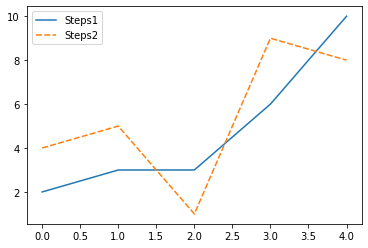

In [269]:
#newtest = test['Steps']
#newtest.index.name = 'Episodes'
#print(newtest)
sns.lineplot(data=test)